In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import scipy.optimize as opt
from PIL import Image
import gzip
import struct


drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Functions

In [ ]:
'''
I use this function to read images from the MNIST dataset.
This file represents 28x28 pixel images, which means we have 784 features for the model.
We can extract features using a filter matrix, for example, but I haven't applied that here.
'''
def read_images(filename: str) -> np.array:
    with open(filename, 'rb') as f:
        magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        image_data = f.read()


        images = np.frombuffer(image_data, dtype=np.uint8)
        images = images.reshape(num_images, rows, cols)

        return images

In [ ]:
'''
I use this function to read labels from the MNIST dataset.
We need it because we are using a classification model, which means supervised learning.
So, these labels are the correct answers for each image.
'''

def read_labels(filename: str) -> np.array:
    with open(filename, 'rb') as f:
        magic, num_labels = struct.unpack(">II", f.read(8))


        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels

In [ ]:
'''
I use this function only with 1 purpose. This function helps me to determine "problem" numbers
"problem" means we have example of number on the border of solution
'''
def draw_image(image: np.array) -> None:
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
'''
It's important to emphasize that the data is being normalized
to bring all features to the same scale.
This ensures that each feature contributes equally to the model training process,
preventing features with larger magnitudes from dominating the optimization algorithm.

I've implemented min max normalize function, to scale all data from 0 to 1.
You can read more about it here: https://en.wikipedia.org/wiki/Normalization_(statistics)
'''

def normalize(X: np.array) -> np.array:
    return (X - X.min()) / (X.max() - X.min())

In [ ]:
'''
I use this function to convert the output from scalar multiplication to probabilities.
In neural networks, this is called an activation function.
For more easiest implementation, you can use softmax function instead of sigmoid,
which is better suited for multiclass classification.
However, according to the plan,
I am implementing it using sigmoid through multiple classifiers.
'''
def sigmoid(z: np.array) -> np.array:
    return 1 / (1 + np.exp(-z))

In [ ]:
def objective_function(theta: np.array, X: np.array, y: np.array) -> float:
    theta = np.matrix(theta).T
    p = sigmoid(X * theta)
    function_value = -(y.T * np.log(p) + (1 - y).T * np.log(1 - p)) / y.size
    return function_value[0, 0]

In [ ]:
def gradient_descent(theta: np.array, X: np.array, y: np.array) -> np.array:
    theta = np.matrix(theta).T
    hThetaX = sigmoid(X * theta)

    gradient = ((hThetaX - y).T * X) / len(y)

    return gradient.T

In [ ]:
def objective_function_regular(theta: np.array, X: np.array, y: np.array, lam: float) -> float:
    value = objective_function(theta, X, y)
    value += lam * np.sum(theta[1:]**2) / (2 * len(y))
    return value

In [ ]:
def gradient_descent_regular(theta: np.array, X: np.array, y: np.array, lam: float) -> float:
    grad = gradient_descent(theta, X, y)
    grad += (np.insert(theta[1:], 0, 0) * lam / len(y)).reshape(-1, 1)

    return grad

In [ ]:
def guess_number(thetas, path):
    image = Image.open(path)
    image = image.convert('L')
    plt.imshow(image, cmap='gray', interpolation='none')
    plt.show()

    temp_image = np.matrix(image).reshape(784, 1).T
    temp_image = np.insert(temp_image, 0, 1, axis=1)
    temp_image = normalize(temp_image)


    all_predictions = []


    for theta in thetas:
        numbers = temp_image * theta.T
        possibility = sigmoid(numbers)
        pred_class = possibility.argmax()
        all_predictions.append(pred_class)

    final_prediction = np.bincount(all_predictions).argmax()

    print(f"This number is {final_prediction}")


# Data Preparing

In [ ]:
sub_path = '/content/drive/My Drive/DataSets/'

train_images = read_images(sub_path + 'train-images.idx3-ubyte')
train_labels = read_labels(sub_path + 'train-labels.idx1-ubyte')

test_images = read_images(sub_path + 't10k-images.idx3-ubyte')
test_labels = read_labels(sub_path + 't10k-labels.idx1-ubyte')

'''
It is important to look the shapes of these matrices
because I will use logistic regression and build 10 classifiers.
For matrix multiplication, certain conditions must be met regarding the dimensions of the matrices.
You can read about it here: https://en.wikipedia.org/wiki/Matrix_(mathematics)
'''

print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")



Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


## Several examples of images and labels

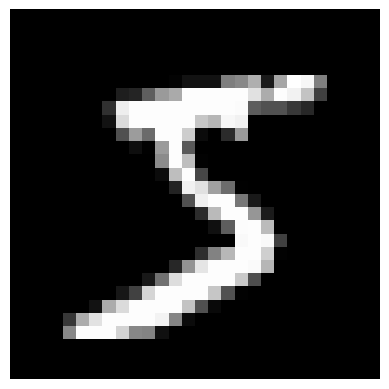

5


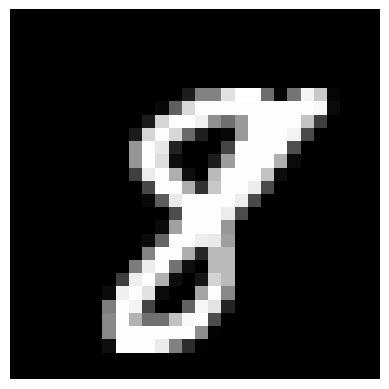

8


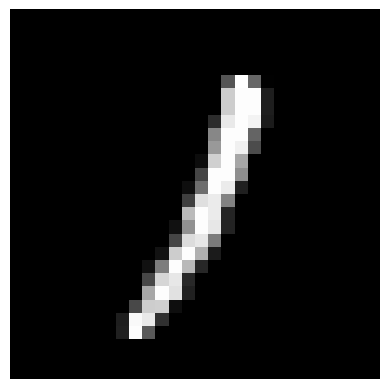

1


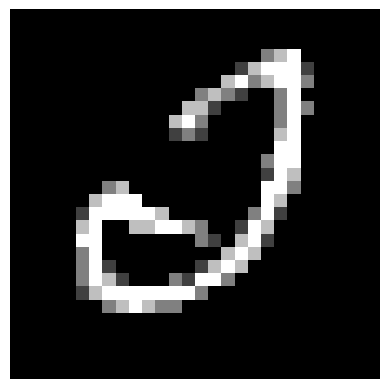

2


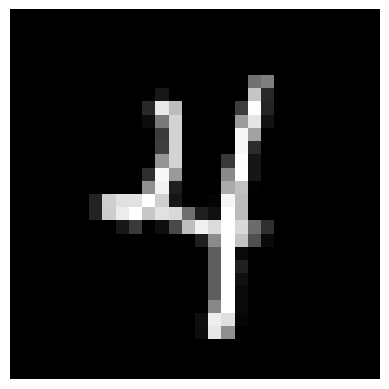

4


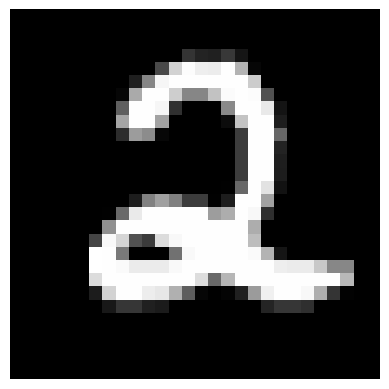

2


In [ ]:
numbers = [0, 55, 99, 178, 1098, 56009]

for i in numbers:
  draw_image(train_images[i])
  print(train_labels[i])

## Creating matrices of features, a vector of labels, and matrices of weights

In [ ]:
train_images = train_images.reshape(60000, 784)
test_images = test_images.reshape(10000, 784)
'''
It's important to emphasize that the data is being normalized.
You can read more about it in Function section
'''
train_images = normalize(train_images)
test_images = normalize(test_images)

In [ ]:
train_images[0]

In [ ]:
X_train = np.matrix(train_images)
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))


y_train = np.matrix(train_labels)
theta = np.zeros((10, X_train.shape[1]))

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(theta.shape)

(60000, 785)
(1, 60000)
(10, 785)


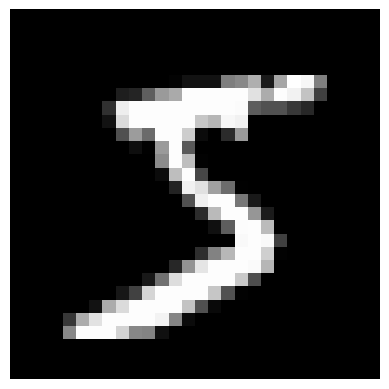

In [ ]:
draw_image(X_train[0, 1:].reshape(28, 28))

# Teaching

In [ ]:
X_train = np.matrix(train_images)
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))


y_train = np.matrix(train_labels)

In [ ]:
X_test = np.matrix(test_images)
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))


y_test = np.matrix(test_labels)

In [ ]:
lambdas = [0.01, 0.1, 0.5, 1, 10, 100]
best_lambda = None
best_accuracy = 0

thetas = []

for lam in lambdas:
    theta = np.zeros((10, X_train.shape[1]))
    for i in range(10):
        yi_train = (y_train == i)
        theta_optimized = opt.fmin_tnc(func=objective_function_regular, x0=theta[i], fprime=gradient_descent_regular, args=(X_train, yi_train.T, lam))
        theta[i] = theta_optimized[0]

    print(lam)

    thetas.append(theta)

print(len(thetas))

In [ ]:
all_predictions = np.zeros((len(thetas), X_test.shape[0]))

for idx, theta in enumerate(thetas):
    predictions = np.array(sigmoid(np.dot(X_test, theta.T)))
    predictions = np.argmax(predictions, axis=1)

    all_predictions[idx] = predictions

ensemble_predictions = [np.bincount(all_predictions[:, i].astype(int)).argmax() for i in range(X_test.shape[0])]

ensemble_predictions = np.array(ensemble_predictions)

ensemble_accuracy = np.mean(ensemble_predictions == y_test) * 100

print(ensemble_predictions)


[7 2 1 ... 4 5 6]


# Checking model accuracy

In [ ]:
values = np.array(sigmoid(np.dot(X_train, theta.T)))
pred_classes = np.argmax(values, axis=1)

In [ ]:
accuracy = np.mean(pred_classes == y_train) * 100
print(accuracy)

93.03166666666667


In [ ]:
values = np.array(sigmoid(np.dot(X_test, theta.T)))
pred_classes = np.argmax(values, axis=1)

In [ ]:
accuracy = np.mean(pred_classes == y_test) * 100
print(accuracy)

91.96


# Result

In [ ]:
numbers = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

for num in numbers:
    guess_number(thetas=thetas, path=f'/content/drive/My Drive/DataSets/numbers/{num}.png')